In [51]:
import numpy as np
from mindaffectBCI.decoder.offline.datasets import get_dataset
import mindaffectBCI.decoder.offline.load_mindaffectBCI 
from mindaffectBCI.decoder.model_fitting import MultiCCA
from mindaffectBCI.decoder.decodingCurveSupervised import decodingCurveSupervised
from mindaffectBCI.decoder.utils import block_permute
from mindaffectBCI.decoder.stim2event import stim2event
from mindaffectBCI.decoder.levelCCA import *
from mindaffectBCI.decoder.multipleCCA import *
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from mindaffectBCI.decoder.analyse_datasets import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
savefile=None

# ask user savefile to load

In [92]:
    %gui tk
    from tkinter import Tk
    from tkinter.filedialog import askopenfilename
    import os
    root = Tk()
    root.withdraw()
    savefile = askopenfilename(initialdir=os.getcwd(),
                                title='Chose mindaffectBCI save File',
                                filetypes=(('mindaffectBCI','mindaffectBCI*.txt'),('All','*.*')))

dataset_loader = mindaffectBCI.decoder.offline.load_mindaffectBCI.load_mindaffectBCI
print(f"savefile={savefile}")

savefile=C:/Users/Developer/Desktop/mark/mindaffectBCI_pattern_reversal_visual_acuity_210204_1912.txt


In [93]:
# manually specify the file to load
dataset_loader = mindaffectBCI.decoder.offline.load_mindaffectBCI.load_mindaffectBCI
if savefile is None:
    savefile = "C:/Users/Developer/Downloads/mindaffectBCI_pattern_reversal_visual_acuity_210204_1912.txt" 

# set the loader args

In [94]:
dataset_args = dict(stopband=((45,65),(5,25,'bandpass')),
                    fs_out = 100)

# load the data

Loading C:/Users/Developer/Desktop/mark/mindaffectBCI_pattern_reversal_visual_acuity_210204_1912.txt
X=(108746, 8) @250.50100200400803Hz
preFilter: 6th butter ((45, 65), (5.5, 25, 'bandpass'))Hz & downsample 250.50100200400803->100Hz
resample: 250.50100200400803->100.20040080160321hz rsrate=2.5
Y=(43499, 1) @100.20040080160321Hz
3 trl_dur (ms) : [91398. 90584. 90812.]
4 trl_stim : [array([5484, 5434, 5448], dtype=int32)]
Got 3 trials, keeping 3
3 trl_dur (samp): [11236 14762]
3 trl_dur (ms) : [112131. 147321.]
slicing 3 trials =[-50 - 9196] samples @ 100.20040080160321Hz


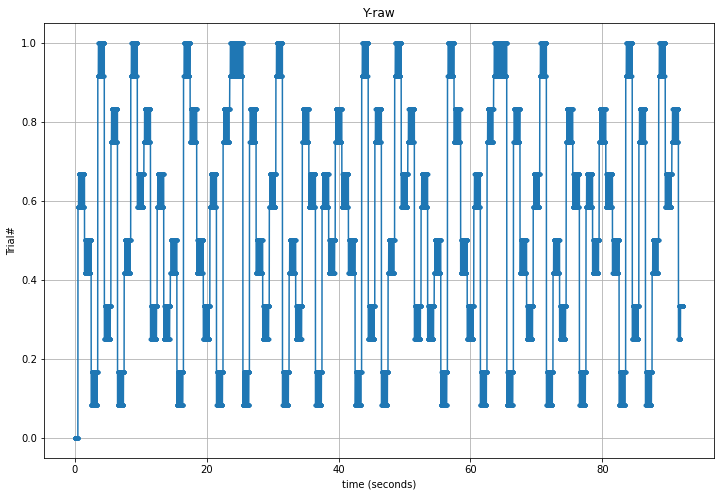

Y_TSy=(3, 9246, 1)


In [95]:
# the data
oX_TSd, oY_TSy, coords = dataset_loader(savefile, *dataset_args)
plot_stim_encoding(oY_TSy[:1,...,0], None, None, coords[1]['fs'])
print(f"Y_TSy={oY_TSy.shape}")

# set up the problem -- trials / event coding etc.

In [96]:
Y_TSy=oY_TSy.copy()
X_TSd=oX_TSd.copy()
outputs = None
label=None
if 'pattern_reversal' in savefile :
        ti=1
        # limit to single trial with single type stimulus
        X_TSd = X_TSd[ti:ti+1,...] 
        Y_TSy = Y_TSy[ti:ti+1,...]

        # convert pairs of levels into outputs
        from mindaffectBCI.decoder.stim2event import oddeven_pattern_reversal
        evtlabs = oddeven_pattern_reversal
        label='reversal'

elif 'visual_acuity' in savefile:
        # strip calibration trials
        X_TSd = X_TSd[10:,...] 
        # and strip true output info
        Y_TSy = Y_TSy[10:,...,1:]

        evtlabs=('re','fe') # ('1')

        # hack assume on a grid
        w = int(np.sqrt(Y_TSy.shape[-1])) 
        h = (Y_TSy.shape[-1]) // w
        outputs= [ (i,j) for i in range(w) for j in range(h)]
        label='visual_acuity'

elif 'threshold' in savefile or 'detection' in savefile:
        # strip calibration trials
        X_TSd = X_TSd[10:,...] 
        # and strip true output info
        Y_TSy = Y_TSy[10:,...,1:]

        # convert levels to outputs so get weighting over them
        evtlabs = 'hot-on'
        label='threshold'

elif 'rc'in savefile:
        evtlabs=('re','ntre')
        label='rc'

else:
        evtlabs=('re','fe')
        # limit to 1st 10 cal trials
        X_TSd = X_TSd[:10,...]
        Y_TSy = Y_TSy[:10,...]

Y_TSye, events = stim2event(Y_TSy,evtlabs)
coords.append(dict(name='event', unit=None, coords=events))

    # set the ch_names dependng on the file type...
if 'face' in savefile:
        coords[2]['coords'] = ('P9','cp5','cp6','P10','O1','POz','O2','Oz') 
elif 'central_cap' in savefile:
        coords[2]['coords'] = ('Cp5','Cp1','Cp2','Cp6','P3','P2','P4','POz')
else:
    coords[2]['coords'] = ('P7','PO7','PO8','P8','Oz','Iz','POz','Cz')
        
fs=coords[1]['fs']
ch_names=coords[2]['coords']

print(f'fs={fs}')
print(f'ch_names={ch_names}')

0) v=1
1) v=3
2) v=5
3) v=7
4) v=9
5) v=11
fs=100.20040080160321
ch_names=('P7', 'P07', 'PO8', 'P8', 'Oz', 'Iz', 'POz', 'Cz')


# Visualize the stimulus coding

savefile=C:/Users/Developer/Desktop/mark/mindaffectBCI_pattern_reversal_visual_acuity_210204_1912.txt
Y_TSye=(1, 9246, 1, 6)
Y_TSy=(1, 9246, 1)
outputs=None
events=[1, 3, 5, 7, 9, 11]


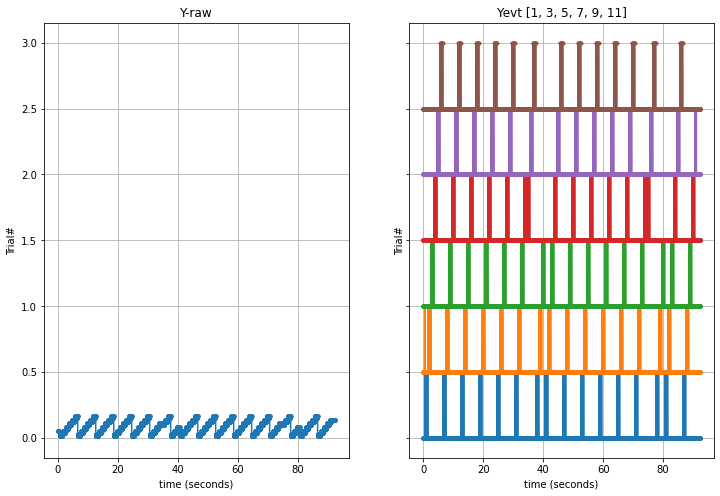

In [97]:
print(f"savefile={savefile}")
print(f"Y_TSye={Y_TSye.shape}")
print(f"Y_TSy={Y_TSy.shape}")
print(f"outputs={outputs}")
print(f"events={events}")
plot_stim_encoding(Y_TSy[:1,...,0], Y_TSye[:1,...,0,:], events, fs)

# set the analysis parameters

In [98]:
tau_ms = 450
offset_ms = 0

tau = int(tau_ms * fs / 1000)
offset = int(offset_ms * fs / 1000)

print(f"tau={tau}")
print(f"offset={offset}")

tau=45
offset=0


# limit the trial length

In [133]:
trlen_sweep = 4
framerate = 60
framesperbit = 6
framesperlevel = 10
trlen_ms = framesperlevel*Yl_TSy.shape[-1]*framesperbit*trlen_sweep* 1000/framerate + 500  # startup + 2-sweeps
trlen_samp = int(fs*trlen_ms / 1000)
print(f"trial_length={trlen_ms}")

trial_length=24500.0


# compute summary statistics

Cxx_dd0 (8, 8)
Cyz_yetd0 (1, 6, 45, 8)
Cyy_yetet0 (1, 6, 45, 6, 45)


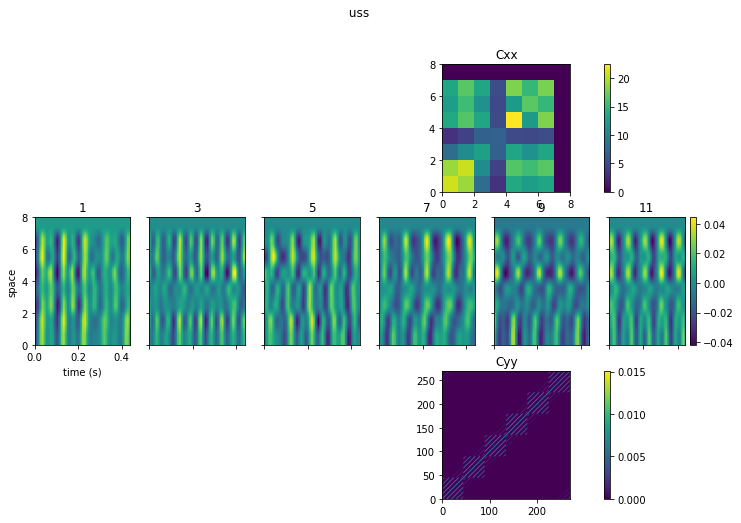

In [134]:
Cxx_dd0, Cyx_yetd0, Cyy_yetet0 = updateSummaryStatistics(X_TSd[...,:trlen_samp,:],Y_TSye[...,:trlen_samp,0:1,:],tau=tau,offset=offset)

print(f"Cxx_dd0 {Cxx_dd0.shape}")
print(f"Cyz_yetd0 {Cyx_yetd0.shape}")
print(f"Cyy_yetet0 {Cyy_yetet0.shape}")

# plot SS
plt.figure()
plot_summary_statistics(Cxx_dd0,Cyx_yetd0,Cyy_yetet0,evtlabs=events,fs=fs)
plt.suptitle(' uss ' )
plt.show(block=False)

# run the normal CCA analysis

A=(1, 8) R=(1, 6, 45)


Text(0.5, 0.98, ' mCCA soln')

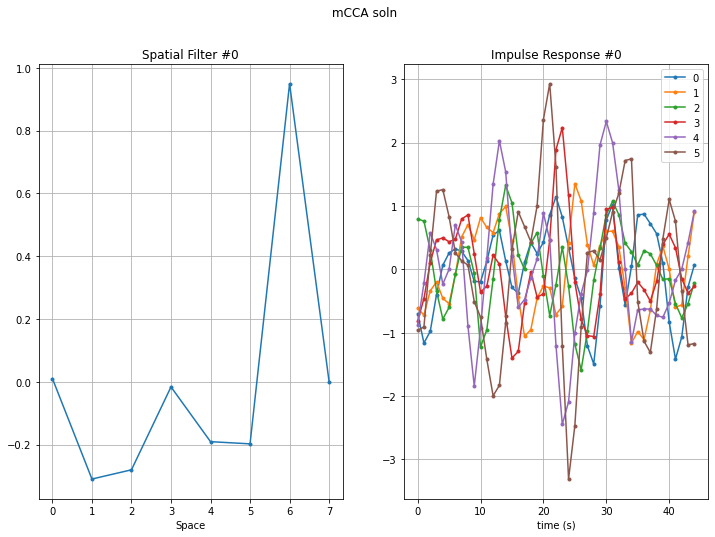

In [135]:
J, W_kd0, R_ket0    = multipleCCA  (Cxx_dd0, Cyx_yetd0, Cyy_yetet0, rcond=1e-6, reg=1e-4, symetric=True)
plt.figure()
plot_factoredmodel(W_kd0,R_ket0)
plt.suptitle(' mCCA soln') 

# convert to levels encoding

In [101]:
if any([ p in savefile for p in ('pattern_reversal','threshold','detection')]):
    print("Levels = {}".format(events))
    Yl_TSy = Y_TSye.reshape((Y_TSye.shape[0],Y_TSye.shape[1],-1)) # compress levels into outputs
        
    outputs = events
    evtlabs=('1')

Levels = [1, 3, 5, 7, 9, 11]


# print the updated encoding

savefile=C:/Users/Developer/Desktop/mark/mindaffectBCI_pattern_reversal_visual_acuity_210204_1912.txt
trlen_ms=24500.0
Y_TSye=(1, 9246, 1, 6)
Y_TSyl=(1, 9246, 6)
outputs=[1, 3, 5, 7, 9, 11]
events=[1, 3, 5, 7, 9, 11]


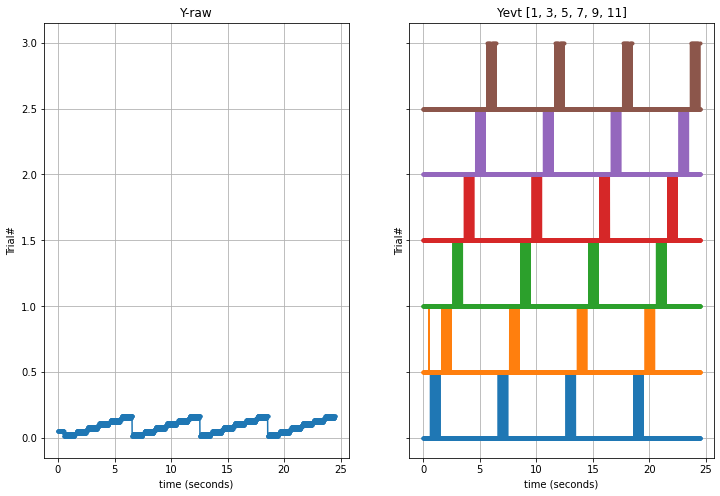

In [128]:
print(f"savefile={savefile}")
print(f"trlen_ms={trlen_ms}")
print(f"Y_TSye={Y_TSye.shape}")
print(f"Y_TSyl={Y_TSyl.shape}")
print(f"outputs={outputs}")
print(f"events={events}")
plot_stim_encoding(Y_TSy[:1,:trlen_samp,0], Yl_TSy[:1,:trlen_samp,:], events, fs)

# Compute the summary statistics and visualize

Cxx_dd (8, 8)
Cyz_yetd (6, 1, 45, 8)
Cyy_tyeye (45, 6, 1, 6, 1)


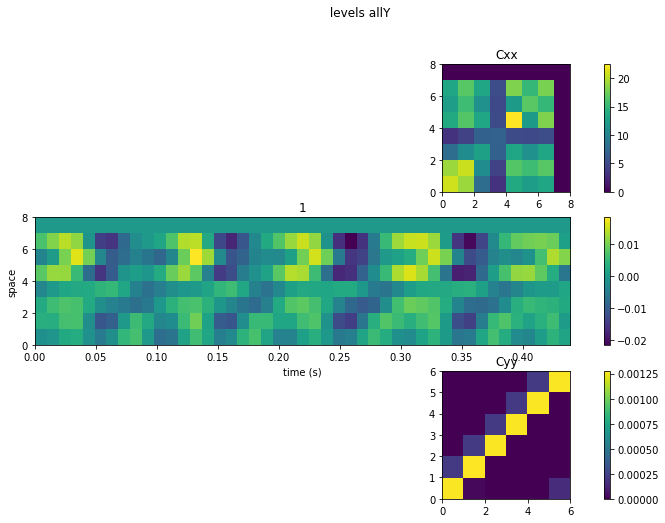

In [129]:
Cxx_dd, Cyx_yetd, Cyy_tyeye = levelsSummaryStatistics(X_TSd[...,:trlen_samp,:],Yl_TSy[...,:trlen_samp,:,np.newaxis],tau=tau,offset=offset)

print(f"Cxx_dd {Cxx_dd.shape}")
print(f"Cyz_yetd {Cyx_yetd.shape}")
print(f"Cyy_tyeye {Cyy_tyeye.shape}")

# plot SS
plt.figure()
plot_summary_statistics(Cxx_dd,Cyx_yetd,Cyy_tyeye,evtlabs=events,fs=fs)
plt.suptitle(' levels allY' )
plt.show(block=False)

# run the levelsCCA and plot the found solution

  0) |S_y|=1.000 dS_y=0.593  J=1.342 dJ=999999998.658
  1) |S_y|=1.000 dS_y=0.188  J=1.126 dJ=0.216
  2) |S_y|=1.000 dS_y=0.039  J=1.035 dJ=0.091
  3) |S_y|=1.000 dS_y=0.016  J=1.023 dJ=0.012
  4) |S_y|=1.000 dS_y=0.009  J=1.022 dJ=0.002
  5) |S_y|=1.000 dS_y=0.005  J=1.021 dJ=0.001
  5) |S_y|=1.000 dS_y=0.005  J=1.021 dJ=0.001
opt) J=1.0210028718527733
W_kd (1, 8)
R_ket (1, 1, 45)
S_y (6,) = [9.95387809e-07 9.95387809e-07 8.51685407e-02 3.17666509e-01
 2.91719720e-01 3.05443240e-01]
trying to get pos from cap file!
A=(1, 8) R=(1, 1, 45)


<Figure size 864x576 with 0 Axes>

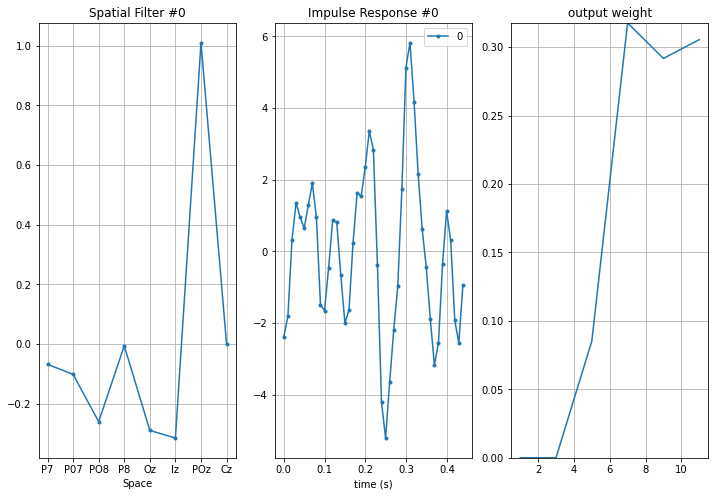

In [130]:
rank=1

J, W_kd, R_ket, S_y = levelsCCA_cov(Cxx_dd, Cyx_yetd, Cyy_tyeye, rank=rank)
print("{}) J={}".format('opt',J))

print(f"W_kd {W_kd.shape}")
print(f"R_ket {R_ket.shape}")
print(f"S_y {S_y.shape} = {S_y}")

# plot soln
plt.figure()
plot_3factoredmodel(W_kd,R_ket,S_y, fs=fs, ch_names=ch_names, outputs=outputs)

# apply S_y and plot the output-weighted summary statistics

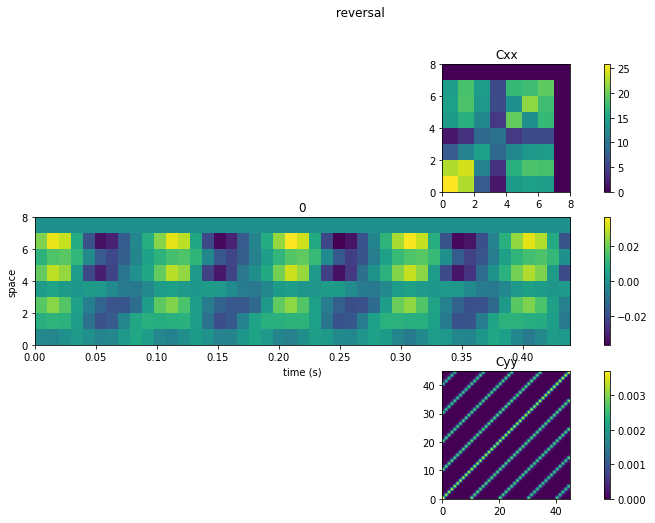

In [105]:
Cyy_yetyet = Mtyeye2Myetyet(Cyy_tyeye)
sCyys_etet = np.einsum("y,yetzfu,z->etfu",S_y,Cyy_yetyet,S_y) 
sCyx_etd = np.einsum('yetd,y->etd',Cyx_yetd,S_y)
plt.figure()
plot_summary_statistics(Cxx_dd,sCyx_etd,sCyys_etet[np.newaxis,...],fs=fs,ch_names=ch_names)
plt.suptitle(' {}'.format(label) )
plt.show(block=False)